In [1]:
from typing import TypedDict, List
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END

# --- 1. SETUP MODEL ---
# Qwen 2.5 (0.5B) is great for following strict formatting instructions
llm = ChatOllama(model="qwen2.5:0.5b", temperature=0.2)

# --- 2. DEFINE STATE ---
# We need to track the inputs (what the user wants) and the output (the plan)
class StudyState(TypedDict):
    subjects: List[str]   # e.g., ["Math", "Physics", "History"]
    hours_available: int  # e.g., 5
    study_plan: str       # The generated schedule

# --- 3. DEFINE NODES ---

def planner_node(state: StudyState):
    subjects = state["subjects"]
    hours = state["hours_available"]
    
    # We create a prompt that forces the LLM to be a "Scheduler"
    # We ask it to break down the time and include breaks.
    prompt = ChatPromptTemplate.from_template(
        """You are an expert academic study planner.
        Create a strict study schedule based on the following constraints:
        
        Subjects to study: {subjects}
        Total Time Available: {hours} hours
        
        Rules:
        1. Divide the time fairly among the subjects.
        2. Include short 5-10 minute breaks between sessions.
        3. Output the plan as a clean list with time slots (assuming start time is Now).
        4. Do not talk. Just output the schedule.
        
        Schedule:"""
    )
    
    # Format the list of subjects into a string
    subjects_str = ", ".join(subjects)
    
    chain = prompt | llm
    response = chain.invoke({"subjects": subjects_str, "hours": hours})
    
    print("✅ Plan Generated!")
    return {"study_plan": response.content}

# --- 4. BUILD GRAPH ---

workflow = StateGraph(StudyState)

workflow.add_node("planner", planner_node)
workflow.set_entry_point("planner")
workflow.add_edge("planner", END)

app = workflow.compile()

# --- 5. RUN IT ---

# Scenario: A student with a heavy exam load tomorrow
print("--- 📚 GENERATING EXAM STUDY PLAN ---")
inputs = {
    "subjects": ["Linear Algebra", "Data Structures", "Economics"],
    "hours_available": 6
}

result = app.invoke(inputs)

print("\n" + "="*20 + " YOUR PLAN " + "="*20)
print(result['study_plan'])
print("="*51)

# Scenario: A light weekend study session
print("\n\n--- ☕ GENERATING WEEKEND REFRESHER PLAN ---")
inputs = {
    "subjects": ["Python Practice", "Reading Novel"],
    "hours_available": 2
}

result = app.invoke(inputs)

print("\n" + "="*20 + " YOUR PLAN " + "="*20)
print(result['study_plan'])
print("="*51)

--- 📚 GENERATING EXAM STUDY PLAN ---
✅ Plan Generated!

==================== YOUR PLAN ====================
Sure, here's a strict study schedule based on your constraints:

1. **Now** - Start studying Linear Algebra.
2. **5 minutes** - Take a short break.
3. **10 minutes** - Continue with Data Structures.
4. **15 minutes** - Take a short break.
5. **20 minutes** - Continue with Economics.
6. **15 minutes** - Take a short break.
7. **5 minutes** - End the day by studying Linear Algebra again.

This schedule ensures that you get 5-10 minutes of breaks between each subject, which helps maintain productivity and prevents burnout.


--- ☕ GENERATING WEEKEND REFRESHER PLAN ---
✅ Plan Generated!

==================== YOUR PLAN ====================
Sure, here's a strict study schedule for Python Practice and Reading Novel:

1. Start Time: Now

2. Break Time: 5 minutes

3. Study Time:
   - Python Practice (5 minutes)
   - Reading Novel (5 minutes)

4. End Time: Now + 10 minutes


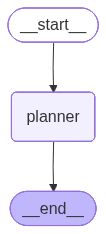

In [2]:
app

## Advanced Ai Study Planner

In [3]:
from typing import TypedDict, List, Optional
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END

# --- 1. SETUP MODEL ---
# Using Qwen 2.5 (0.5B) - Low temperature for strict logic
llm = ChatOllama(model="qwen2.5:0.5b", temperature=0.1)

# --- 2. DEFINE STATE ---
class StudyState(TypedDict):
    subjects: List[str]
    hours_available: float
    study_plan: str
    feedback: Optional[str]   # Error message from Reviewer
    is_valid: bool            # Pass/Fail flag
    final_output: str         # The plan + links combined

# --- 3. DEFINE NODES ---

def planner_node(state: StudyState):
    print(f"✍️ Planner: Generating schedule for {state['hours_available']} hours...")
    
    subjects_str = ", ".join(state['subjects'])
    feedback = state.get("feedback", "")
    
    # If there is feedback (rejection), we add it to the prompt
    feedback_instruction = ""
    if feedback:
        print(f"   ⚠️ Fixing previous error: {feedback}")
        feedback_instruction = f"PREVIOUS ATTEMPT REJECTED. FEEDBACK: {feedback}. FIX THIS."

    prompt = ChatPromptTemplate.from_template(
        """You are a strict study scheduler.
        Task: Create a study plan for: {subjects}
        Total Time Limit: {hours} hours.
        {feedback_instruction}
        
        Constraints:
        1. The total time of all sessions MUST sum up exactly to {hours} hours.
        2. Break the time down into specific slots (e.g., "10:00 - 11:00").
        3. Output ONLY the schedule text.
        """
    )
    
    chain = prompt | llm
    response = chain.invoke({
        "subjects": subjects_str, 
        "hours": state['hours_available'],
        "feedback_instruction": feedback_instruction
    })
    
    return {"study_plan": response.content, "feedback": None} # Clear old feedback

def reviewer_node(state: StudyState):
    print("🧐 Reviewer: Checking the math...")
    plan = state["study_plan"]
    hours_limit = state["hours_available"]
    
    # We ask the LLM to verify its own work (Self-Reflection)
    prompt = ChatPromptTemplate.from_template(
        """You are a math auditor. 
        Review this study plan and sum up the total study hours listed.
        
        Plan:
        {plan}
        
        Target Limit: {hours} hours.
        
        If the total time is significantly different from the target (more than 30 mins off), say "FAIL" and explain why.
        If it is correct (or very close), say "PASS".
        
        Output format: PASS or FAIL: [Reason]
        """
    )
    
    chain = prompt | llm
    response = chain.invoke({"plan": plan, "hours": hours_limit})
    result = response.content.strip()
    
    if "FAIL" in result:
        print(f"   ❌ Review Rejected: {result}")
        return {"is_valid": False, "feedback": result}
    else:
        print("   ✅ Review Passed!")
        return {"is_valid": True}

def resource_node(state: StudyState):
    print("🔎 Resource Finder: Fetching materials...")
    subjects = state["subjects"]
    plan = state["study_plan"]
    
    # Since we can't browse the live web, we generate helpful search URLs
    resources = []
    for sub in subjects:
        # Create a YouTube Search URL
        query = sub.replace(" ", "+")
        url = f"https://www.youtube.com/results?search_query={query}+tutorial"
        resources.append(f"📺 {sub}: {url}")
        
    resource_text = "\n".join(resources)
    
    final_text = f"{plan}\n\n--- 📚 RECOMMENDED RESOURCES ---\n{resource_text}"
    return {"final_output": final_text}

# --- 4. DEFINE LOGIC (ROUTER) ---

def route_decision(state: StudyState):
    if state["is_valid"]:
        return "resource_node"
    else:
        return "planner" # Loop back!

# --- 5. BUILD GRAPH ---

workflow = StateGraph(StudyState)

workflow.add_node("planner", planner_node)
workflow.add_node("reviewer", reviewer_node)
workflow.add_node("resource_node", resource_node)

workflow.set_entry_point("planner")

workflow.add_edge("planner", "reviewer")

workflow.add_conditional_edges(
    "reviewer",
    route_decision,
    {
        "resource_node": "resource_node",
        "planner": "planner"
    }
)

workflow.add_edge("resource_node", END)

app = workflow.compile()

# --- 6. RUN IT ---

inputs = {
    "subjects": ["React JS", "Linear Algebra"],
    "hours_available": 3
}

# Recursion limit is safety for loops (stops it if it fails 20 times)
final_state = app.invoke(inputs, config={"recursion_limit": 10})

print("\n" + "="*20 + " FINAL PLAN " + "="*20)
print(final_state['final_output'])

✍️ Planner: Generating schedule for 3 hours...


KeyboardInterrupt: 